In [273]:
import numpy as np
import pandas as pd
from glob import glob
import datetime
from pyproj import Transformer
import matplotlib.pyplot as plt
import wradlib as wrl
import re
import geopandas as gpd

# Data and URLs

In [292]:
# Drainage and raingauge url
URL_gauge_data = 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges/'
URL_gauge_2020_file = URL_gauge_data + 'clean2020data1475.csv'
URL_saved_sensor_data = URL_gauge_data + 'hbs_lysigogn.csv'
DIR_data = 'C:/Users/sverrirhd/vedurgogn/'
DIR_rain_gauges = glob(URL_gauge_data + '*cleaned*')


# Radar urls
# DIR_CAPPI = 'C:/Users/sverrirhd/OneDrive/CAPPI/'
# DIR_CAPPI = 'F:/CAPPI/'
DIR_CAPPI = 'F:/CAPPI_2/'

urls_cappi = np.array(glob(DIR_CAPPI + 'CAPPI_[0-9][0-9][0-9][0-9][0-9][0-9]*'))
urls_cappi_mask = np.array(glob(DIR_CAPPI + 'CAPPI_MASK*'))
urls_descr = np.array(glob(DIR_CAPPI + 'descriptive_data*'))
urls_probl = np.array(glob(DIR_CAPPI + 'problematic_indexes*'))
urls_urls = np.array(glob(DIR_CAPPI + 'urls*'))

urls_cappi_2020 = urls_cappi[['2020' in i for i in urls_cappi]]
urls_cappi_mask_2020 = urls_cappi_mask[['2020' in i for i in urls_cappi_mask]]
urls_descr_2020 = urls_descr[['2020' in i for i in urls_descr]]
urls_probl_2020 = urls_probl[['2020' in i for i in urls_probl] ]
urls_urls_2020 = urls_urls[['2020' in i for i in urls_urls]]

urls_cappi = urls_cappi[[url not in urls_cappi_2020 for url in urls_cappi]]
urls_cappi_mask = urls_cappi_mask[[url not in urls_cappi_mask_2020 for url in urls_cappi_mask]]
urls_descr = urls_descr[[url not in urls_descr_2020 for url in urls_descr]]
urls_probl = urls_probl[[url not in urls_probl_2020 for url in urls_probl]]
urls_urls = urls_urls[[url not in urls_urls_2020 for url in urls_urls]]

df_file_urls = pd.DataFrame([urls_cappi,urls_cappi_mask,urls_descr,urls_probl,urls_urls]).T
df_file_urls.columns = ['CAPPI','CAPPI_mask','descriptive_data','problematic_indexes','urls']
df_file_urls.loc[:,'yearmonth'] = df_file_urls.CAPPI.astype(str).str.findall('[0-9][0-9][0-9][0-9][0-9][0-9]').apply(lambda x : x[0])

df_file_urls.loc[:,'filetype'] = df_file_urls.CAPPI.astype(str).str.findall('hdf5').apply(lambda x: 'hdf5' if len(x) > 0 else 'h5')


In [293]:
# DIR_save = 'F:/CAPPI/'
# missing_dates = np.load(DIR_save + 'missing_dates_all.npy', allow_pickle=True)

In [294]:
DIR_rain_gauges

['C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges\\1473_cleaned',
 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges\\1474_cleaned',
 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges\\1475_cleaned',
 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges\\1478_cleaned',
 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges\\1481_cleaned',
 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges\\1482_cleaned',
 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges\\1485_cleaned',
 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges\\1578_cleaned']

## Raingauge and drainage data

In [295]:
# Rain gauge metadata
df_sensors = pd.read_csv(URL_saved_sensor_data, sep='\t', encoding='Windows-1252')

# Rain gauges - Review processing of this data before proceeding 
rain_gauage_ids = [re.findall('[0-9][0-9][0-9][0-9]',i)[0] for i in DIR_rain_gauges]
gauges_raw = pd.DataFrame([pd.read_pickle(i) for i in DIR_rain_gauges],index = rain_gauage_ids).T
gauges_raw_hour = gauges_raw.resample('1h').sum().rename(lambda x : str(x) + '_R_raw',axis=1)

# Processed rain gauge data
gauges_clean_long = pd.read_csv(URL_gauge_data + 'yfirfarid_hbs.csv',sep='\t')
gauges_clean_long.TIMI = pd.to_datetime(gauges_clean_long.TIMI)
gauges_clean = gauges_clean_long.pivot_table(values='R',index='TIMI',columns='STOD')
gauges_clean = gauges_clean.rename(lambda x : str(x) + '_R_manual',axis=1)

# All rain gauge data 
gauges = pd.concat([gauges_raw_hour,gauges_clean],axis=1)
first_non_0 = gauges.fillna(0).apply(lambda x : np.argwhere(x.values != 0)[0])
gauges = gauges.apply(lambda x : x.iloc[first_non_0.loc[:,x.name][0]:])  

# Remove rediculous outliers (53 is larges in manual dataset)
gauges[gauges.values > 55]= np.nan

# other variables
df_temperature =  pd.read_pickle('../Rainfall - runoff/temperature_data.pkl')
df_temperature = df_temperature.rename(lambda x : str(x) + '_T',axis=1)

# Drainage flow data
df_target = pd.read_pickle('../Drainage data/all_drainage_data_uncorrected.pkl')
df_target = df_target.drop(['MOS-HOL','KOP-HAB'],axis=1)


In [296]:
rain_gauage_ids

['1473', '1474', '1475', '1478', '1481', '1482', '1485', '1578']

## Geo data

In [297]:
sitecoords = (-22.636, 64.025, 45.0)

postnr = gpd.read_file('../Radar data analysis/Radar visualization/Shapefiles/postnr/postnrs.shp')
coords = np.load('../Radar processing/CAPPI_pixel_coords.npy')

transformer_gps_isl = Transformer.from_crs("epsg:4326", "epsg:3057" ) # Umbreyta GPS staðsetningu yfir í cartesian hnit fyrir Ísland
transformer_isl_gps = Transformer.from_crs("epsg:3057", "epsg:4326") # Umbreyta cartesian hnitum aftur í GPS hnit

radar_x,radar_y = transformer_gps_isl.transform(sitecoords[1],sitecoords[0])
gauge_x,gauge_y = transformer_gps_isl.transform(64.1275,-21.902)


radar_width_in_image = (602*240/250+1)
pixel_distance = ((coords[:,:2] - [gauge_x,gauge_y])**2).sum(axis=1)**0.5
idx_closest_pixel = pixel_distance.argmin()
pixel_distance[idx_closest_pixel],idx_closest_pixel
gauge_idx,gauge_idy = idx_closest_pixel//602,idx_closest_pixel%602

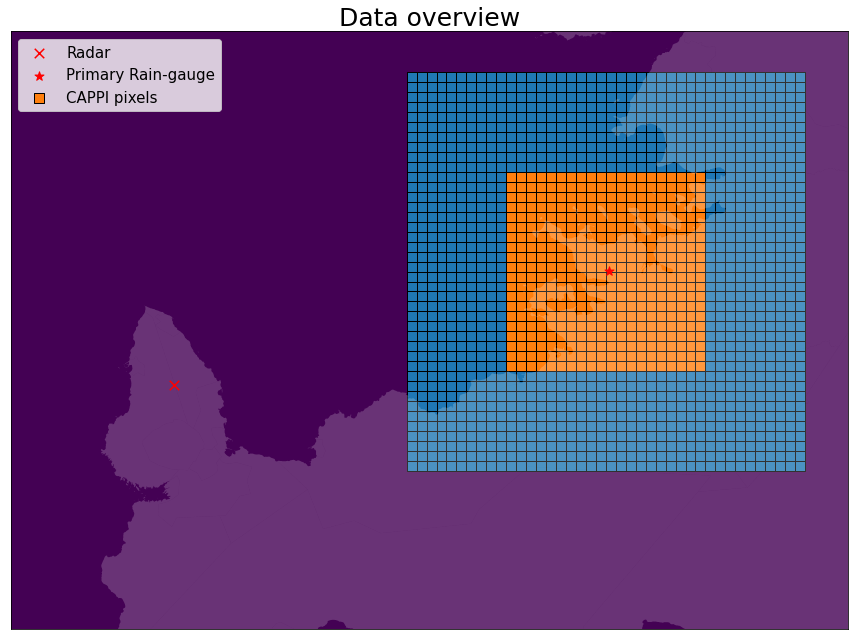

In [298]:
margin_extra = 20
margin = 10
# margin = 30

CAPPI_indexes = np.arange(602**2).reshape(602,602)

cappi_idx_extra = CAPPI_indexes[gauge_idx-margin_extra:gauge_idx+margin_extra,gauge_idy-margin_extra:gauge_idy+margin_extra].ravel()
cappi_idx = CAPPI_indexes[gauge_idx-margin:gauge_idx+margin,gauge_idy-margin:gauge_idy+margin].ravel()

plt.figure(figsize=(15,15))
pixels_handle_extra = plt.scatter(coords[cappi_idx_extra,0],coords[cappi_idx_extra,1],s = 100,marker = 's',edgecolors='black')
pixels_handle = plt.scatter(coords[cappi_idx,0],coords[cappi_idx,1],s = 100,marker = 's',edgecolors='black')

postnr.geometry.plot(ax = plt.gca(),alpha = 0.2,color='white')

radar_handle = plt.scatter(radar_x,radar_y,c ='red',marker = 'x',s = 90)
gauge_handle = plt.scatter(gauge_x,gauge_y,c ='red',marker = '*',s = 90)

plt.ylim(gauge_y - 30_000,gauge_y + 20_000)
plt.xlim(gauge_x - 50_000,gauge_x + 20_000)
plt.xticks([],[])
plt.yticks([],[])
plt.gca().set_facecolor((0.267004, 0.004874, 0.329415, 1.0))
plt.title('Data overview',fontsize=25)
plt.legend([radar_handle,gauge_handle,pixels_handle],['Radar','Primary Rain-gauge','CAPPI pixels'],loc = 'upper left',fontsize=15)
plt.show()

# Load all cappi data

In [299]:
cappi_dict = {}
cappi_extra_dict = {}
urls_dict = {}
filetypes_dict = {}

In [300]:
df_file_urls

,CAPPI,CAPPI_mask,descriptive_data,problematic_indexes,urls,yearmonth,filetype
0,F:/CAPPI_2\CAPPI_201501.npy,F:/CAPPI_2\CAPPI_MASK_201501.npy,F:/CAPPI_2\descriptive_data201501.npy,F:/CAPPI_2\problematic_indexes201501.npy,F:/CAPPI_2\urls201501.npy,201501,h5
1,F:/CAPPI_2\CAPPI_201502.npy,F:/CAPPI_2\CAPPI_MASK_201502.npy,F:/CAPPI_2\descriptive_data201502.npy,F:/CAPPI_2\problematic_indexes201502.npy,F:/CAPPI_2\urls201502.npy,201502,h5
2,F:/CAPPI_2\CAPPI_201503.npy,F:/CAPPI_2\CAPPI_MASK_201503.npy,F:/CAPPI_2\descriptive_data201503.npy,F:/CAPPI_2\problematic_indexes201503.npy,F:/CAPPI_2\urls201503.npy,201503,h5
3,F:/CAPPI_2\CAPPI_201504.npy,F:/CAPPI_2\CAPPI_MASK_201504.npy,F:/CAPPI_2\descriptive_data201504.npy,F:/CAPPI_2\problematic_indexes201504.npy,F:/CAPPI_2\urls201504.npy,201504,h5
4,F:/CAPPI_2\CAPPI_201505.npy,F:/CAPPI_2\CAPPI_MASK_201505.npy,F:/CAPPI_2\descriptive_data201505.npy,F:/CAPPI_2\problematic_indexes201505.npy,F:/CAPPI_2\urls201505.npy,201505,h5
...,...,...,...,...,...,...,...
58,F:/CAPPI_2\CAPPI_201908_hdf5.npy,F:/CAPPI_2\CAPPI_MASK_201908_hdf5.npy,F:/CAPPI_2\descriptive_data201908_hdf5.npy,F:/CAPPI_2\problematic_indexes201908_hdf5.npy,F:/CAPPI_2\urls201908_hdf5.npy,201908,hdf5
59,F:/CAPPI_2\CAPPI_201909_hdf5.npy,F:/CAPPI_2\CAPPI_MASK_201909_hdf5.npy,F:/CAPPI_2\descriptive_data201909_hdf5.npy,F:/CAPPI_2\problematic_indexes201909_hdf5.npy,F:/CAPPI_2\urls201909_hdf5.npy,201909,hdf5
60,F:/CAPPI_2\CAPPI_201910_hdf5.npy,F:/CAPPI_2\CAPPI_MASK_201910_hdf5.npy,F:/CAPPI_2\descriptive_data201910_hdf5.npy,F:/CAPPI_2\problematic_indexes201910_hdf5.npy,F:/CAPPI_2\urls201910_hdf5.npy,201910,hdf5
61,F:/CAPPI_2\CAPPI_201911_hdf5.npy,F:/CAPPI_2\CAPPI_MASK_201911_hdf5.npy,F:/CAPPI_2\descriptive_data201911_hdf5.npy,F:/CAPPI_2\problematic_indexes201911_hdf5.npy,F:/CAPPI_2\urls201911_hdf5.npy,201911,hdf5


## load into dictionaries

In [302]:
# Takes about 90s (on hard drive, but more like 20 minutes from external hard drive) 
for index,row in df_file_urls.iterrows():
    urls = row['urls']
    year_month = row['yearmonth']
    filetype = row['filetype']
    CAPPI_url = row['CAPPI']
    problematic_indx = row['problematic_indexes']
    
    key = (year_month,filetype)
    print(key)
    if key in cappi_extra_dict.keys():
        continue
    
    CAPPI_flat = np.load(CAPPI_url).reshape(-1,602**2)
    
    CAPPI_subset = CAPPI_flat[:,cappi_idx]
    CAPPI_extra_subset = CAPPI_flat[:,cappi_idx_extra]
    
    cappi_dict[key] = CAPPI_subset
    cappi_extra_dict[key] = CAPPI_extra_subset
    urls_dict[key] = np.load(urls,allow_pickle=True)
    filetypes_dict[key] = filetype
    # if index == 11+2*12:
    #     break

('201501', 'h5')
('201502', 'h5')
('201503', 'h5')
('201504', 'h5')
('201505', 'h5')
('201506', 'h5')
('201507', 'h5')
('201508', 'h5')
('201509', 'h5')
('201510', 'h5')
('201511', 'h5')
('201512', 'h5')
('201601', 'h5')
('201602', 'h5')
('201603', 'h5')
('201604', 'h5')
('201605', 'h5')
('201606', 'h5')
('201607', 'h5')
('201608', 'h5')
('201609', 'h5')
('201610', 'h5')
('201611', 'h5')
('201612', 'h5')
('201701', 'h5')
('201702', 'h5')
('201703', 'h5')
('201704', 'h5')
('201705', 'h5')
('201706', 'h5')
('201707', 'h5')
('201708', 'h5')
('201709', 'h5')
('201710', 'h5')
('201711', 'h5')
('201712', 'h5')
('201801', 'h5')
('201801', 'hdf5')
('201802', 'h5')
('201802', 'hdf5')
('201803', 'h5')
('201803', 'hdf5')
('201804', 'hdf5')
('201805', 'hdf5')
('201806', 'hdf5')
('201807', 'hdf5')
('201808', 'hdf5')
('201809', 'hdf5')
('201810', 'hdf5')
('201811', 'hdf5')
('201812', 'hdf5')
('201901', 'hdf5')
('201902', 'hdf5')
('201903', 'hdf5')
('201904', 'hdf5')
('201905', 'hdf5')
('201906', 'hd

In [303]:
# plt.imshow(cappi_extra_dict[('201501','h5')][0].reshape(40,40))
# plt.show()
# plt.imshow(cappi_dict[('201501','h5')][0].reshape(20,20))
# plt.show()

## Restore original echo with offset and gain

In [304]:
extract_datestring = lambda x : re.findall('20[1-2][5-9][0-1][0-9][0-3][0-9][0-2][0-9][0-5][0-9]',x.replace('_',''))
extract_date = lambda x : datetime.datetime(int(x[:4]),int(x[4:6]),int(x[6:8]),int(x[8:10]),int(x[10:12]))
cappi_dataframe_dict = dict()
cappi_extra_dataframe_dict = dict()
for (year_month, filetype) in cappi_dict.keys():
    key = (year_month, filetype)
    
    CAPPI_subset = cappi_dict[key] 
    CAPPI_subset_extra = cappi_extra_dict[key] 
    urls = urls_dict[key]
    filetype = filetypes_dict[key]
    
    # print(urls)
    datestrings = [extract_datestring(url[0]) for url in urls] 
    datetimes = [extract_date(datestr[0]) for datestr in datestrings]
    
    #################### Because of missing files that werent logged originally
    # datetimes = [i for i in datetimes if i not in dt_missing_dates]
    # print(len(datestrings),len(datetimes))
    #################### Because of missing files that werent logged originally
    
    print(key)
    try:
        df_cappi_subset = pd.DataFrame(CAPPI_subset,index = datetimes,dtype = 'float')
        df_cappi_subset_extra = pd.DataFrame(CAPPI_subset_extra,index = datetimes,dtype = 'float')
    except:
        continue
    
    # df_cappi_subset[df_cappi_subset >= 215] = np.nan # Reconsider after recomputing CAPPI without 255 values
    if filetype == 'h5':    
        df_cappi_subset = (df_cappi_subset) * 0.4 - 30
        df_cappi_subset_extra = (df_cappi_subset_extra) * 0.4 - 30
    elif filetype == 'hdf5':
        df_cappi_subset = (df_cappi_subset) * 0.5 - 32
        df_cappi_subset_extra = (df_cappi_subset_extra) * 0.5 - 32
    else:
        assert False
        
    # If both data sources exist, use the newer one
    if year_month in cappi_dataframe_dict:
        if filetype == 'hdf5':
            cappi_dataframe_dict[year_month] = df_cappi_subset
            cappi_extra_dataframe_dict[year_month] = df_cappi_subset_extra
    else:
        cappi_dataframe_dict[year_month] = df_cappi_subset
        cappi_extra_dataframe_dict[year_month] = df_cappi_subset_extra

('201501', 'h5')
('201502', 'h5')
('201503', 'h5')
('201504', 'h5')
('201505', 'h5')
('201506', 'h5')
('201507', 'h5')
('201508', 'h5')
('201509', 'h5')
('201510', 'h5')
('201511', 'h5')
('201512', 'h5')
('201601', 'h5')
('201602', 'h5')
('201603', 'h5')
('201604', 'h5')
('201605', 'h5')
('201606', 'h5')
('201607', 'h5')
('201608', 'h5')
('201609', 'h5')
('201610', 'h5')
('201611', 'h5')
('201612', 'h5')
('201701', 'h5')
('201702', 'h5')
('201703', 'h5')
('201704', 'h5')
('201705', 'h5')
('201706', 'h5')
('201707', 'h5')
('201708', 'h5')
('201709', 'h5')
('201710', 'h5')
('201711', 'h5')
('201712', 'h5')
('201801', 'h5')
('201801', 'hdf5')
('201802', 'h5')
('201802', 'hdf5')
('201803', 'h5')
('201803', 'hdf5')
('201804', 'hdf5')
('201805', 'hdf5')
('201806', 'hdf5')
('201807', 'hdf5')
('201808', 'hdf5')
('201809', 'hdf5')
('201810', 'hdf5')
('201811', 'hdf5')
('201812', 'hdf5')
('201901', 'hdf5')
('201902', 'hdf5')
('201903', 'hdf5')
('201904', 'hdf5')
('201905', 'hdf5')
('201906', 'hd

In [305]:
df_cappi_all = pd.concat(list(cappi_dataframe_dict.values()))
df_cappi_extra_all = pd.concat(list(cappi_extra_dataframe_dict.values()))

In [306]:
# df_cappi_extra_all.to_pickle('40x40radar_echo_comparison.pkl')
df_cappi_extra_all.to_pickle('40x40radar_echo_2km.pkl')
# df_cappi_extra_all.to_pickle('40x40radar_echo_1_25km.pkl')

In [149]:
def to_rainfall(radar_data,a,b):
    return wrl.zr.z_to_r(wrl.trafo.idecibel(radar_data), a=a, b=b)
compute_rain = lambda x : to_rainfall(x,200,1.6)

# Compute optimal Z-R relationship in terms of MAE and MSE

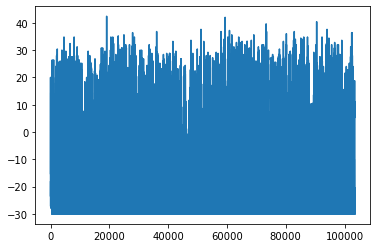

In [120]:
plt.plot(df_cappi_all.values[:,0])
plt.show()

<AxesSubplot:xlabel='TIMI'>

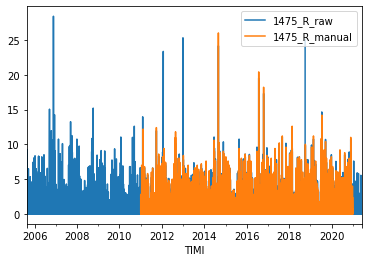

In [121]:
(gauges.loc[:,['1475_R_raw']]).plot()
(gauges.loc[:,['1475_R_manual']] * 2).plot(ax = plt.gca())

In [122]:
d_start = datetime.datetime(2015,1,1)
d_end = datetime.datetime(2019,12,31,23,59,59)

z = df_cappi_all.loc[:,310]#.resample('300s').mean().interpolate()
g = 0.5*gauges.loc[d_start:d_end,'1475_R_raw']#.resample('300s').mean().interpolate()

def compute_loss(x0):
    a,b = x0
    r = to_rainfall(z,a,b)
    loss = np.mean((r-g)**2)
    return loss

from scipy.optimize import minimize
x0 = np.array([200,1.6])
results = minimize(compute_loss,x0)

r = to_rainfall(z,*results.x)
r.shift(-3).corr(g),results.x

(0.5675619417512086, array([413.76063235,   3.95123131]))

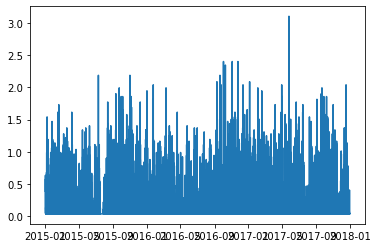

In [123]:
plt.plot(r)

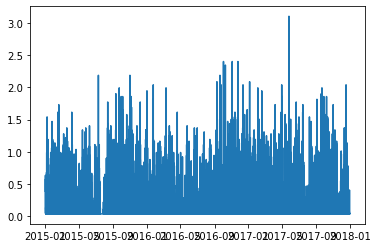

In [124]:
plt.plot(r)

In [125]:
r = compute_rain(z)
r.shift(-3).corr(g)

0.46985598925848154

In [126]:
d_start = datetime.datetime(2015,1,1)
d_end = datetime.datetime(2019,12,31,23,59,59)
g =  gauges.loc[d_start:d_end,'1475_R_manual']
g_daily = g.resample('1d').mean()

In [176]:
# df_cappi_all_rainfall = to_rainfall(df_cappi_all,*results.x)
# df_cappi_all_rainfall = to_rainfall(df_cappi_all,*results.x)
# df_cappi_all_rainfall = compute_rain(df_cappi_all)
df_cappi_all_rainfall = compute_rain(df_cappi_extra_all)

In [151]:
# df_cappi_all_rainfall.to_pickle('20x20cappi_rainfall_1_25_to_2018.pkl',)

# Further analysis

In [177]:
rainfall_bins = [(0,0.5),(0.5,2),(2,5),(5,10),(10,30),(30,100)]
gs = []
for low,high in rainfall_bins:
    g_sub = g[((g<high) & (g >= low))]
    gs.append(len(g_sub))
gs = np.array(gs)
print((gs/len(g)*100).round(2).tolist())

[87.97, 9.0, 2.57, 0.44, 0.03, 0.0]


In [178]:
g_sim = df_cappi_all_rainfall.values.ravel()

rainfall_bins = [(0,0.5),(0.5,2),(2,5),(5,10),(10,30),(30,100)]
gs = []
for low,high in rainfall_bins:
    g_sub = g_sim[((g_sim<high) & (g_sim >= low))]
    gs.append(len(g_sub))
gs = np.array(gs)
print((gs/len(g_sim)*100).round(2).tolist())

[95.24, 4.2, 0.51, 0.05, 0.0, 0.0]


In [179]:
# from missingno import matrix 
# matrix(gauges)

In [197]:
# gauges

In [211]:
d_start = datetime.datetime(2015,1,1)
d_end = datetime.datetime(2019,12,31,23,59,59)

corrs = []
# x_gauge = gauges.loc[d_start:d_end,'1473_R_manual']
x_gauge = gauges.loc[d_start:d_end,'1475_R_manual']
# x_gauge = gauges.loc[d_start:d_end,'1475_R_raw']
for col in df_cappi_all_rainfall:
    x_radar = df_cappi_all_rainfall.loc[d_start:d_end,col]
    corr_tmp = x_radar.resample('1h').mean().corr(x_gauge.resample('1h').mean())
    # corr_tmp = x_radar.resample('7d').mean().corr(x_gauge.resample('7d').mean())
    # corr_tmp = x_radar.corr(x_gauge)
    corrs.append(corr_tmp)
corrs_1475 = np.array(corrs)
best_pixel_1475 = np.argmax(corrs)
worst_pixel_1475 = np.argmin(corrs)
print(corrs_1475[best_pixel_1475],best_pixel_1475)
print(corrs_1475[worst_pixel_1475],worst_pixel_1475)

0.4771176396513186 1187
0.16358631734029883 1309


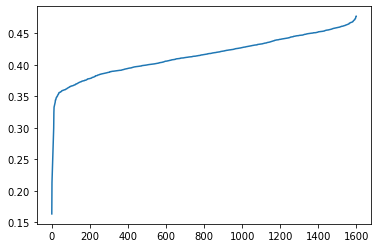

In [212]:
plt.plot(sorted(corrs_1475))

# Selecting the pixel right on top of the rain-gauge, check lagging correlation

In [213]:
closest_to_gauge_idx = np.linalg.norm(coords[:,:2] - [gauge_x,gauge_y],axis=1).argmin()

In [214]:
closest_to_gauge_idx = np.linalg.norm(coords[cappi_idx,:2] - [gauge_x,gauge_y],axis=1).argmin()

In [257]:
r = df_cappi_all_rainfall.loc[:,closest_to_gauge_idx]#.resample('300s').mean().interpolate()
# g = gauges.loc[d_start:d_end,'1475_R_manual']#.resample('300s').mean().interpolate()
g = gauges.loc[d_start:d_end,'1475_R_manual']#.resample('300s').mean().interpolate()
shifts = range(-20,20)
lag_corrs = []
for s in shifts:
    lc = r.shift(s).resample('1h').mean().corr(g)
    lag_corrs.append(lc)
lag_argmax = np.argmax(lag_corrs)
print('optimal lag:',shifts[lag_argmax],lag_corrs[lag_argmax])

optimal lag: 4 0.5926782522100971


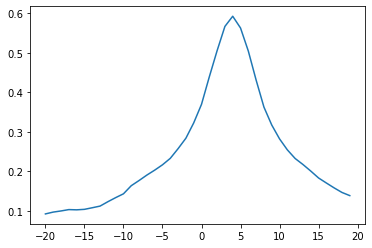

In [258]:
plt.plot(shifts,lag_corrs)
plt.show()

In [259]:
d_start = datetime.datetime(2015,1,1)
d_end = datetime.datetime(2019,12,31,23,59,59)

corrs = []
x_gauge = gauges.loc[d_start:d_end,'1475_R_manual']
# x_gauge = gauges.loc[d_start:d_end,'1473_R_manual']
# x_gauge = gauges.loc[d_start:d_end,'1473_R_manual']
#.resample('300s').mean().interpolate()
for col in df_cappi_all_rainfall:
    x_radar = df_cappi_all_rainfall.loc[:,col].shift(4)#.resample('300s').mean().interpolate().shift(-2)
    corr_tmp = x_radar.resample('1h').mean().corr(x_gauge)
    # corr_tmp = x_radar.resample('7d').mean().corr(x_gauge.resample('7d').mean())
    # corr_tmp = x_radar.corr(x_gauge)
    corrs.append(corr_tmp)
corrs_1475 = np.array(corrs)
best_pixel_1475 = np.argmax(corrs)
worst_pixel_1475 = np.argmin(corrs)
print(corrs_1475[best_pixel_1475],best_pixel_1475)
print(corrs_1475[worst_pixel_1475],worst_pixel_1475)

0.7090553438135481 736
0.17173610097509803 1309


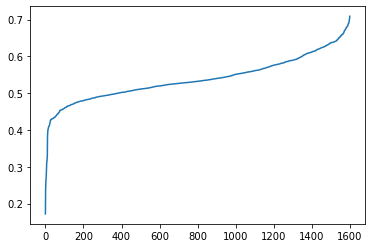

In [260]:
plt.plot(sorted(corrs_1475))

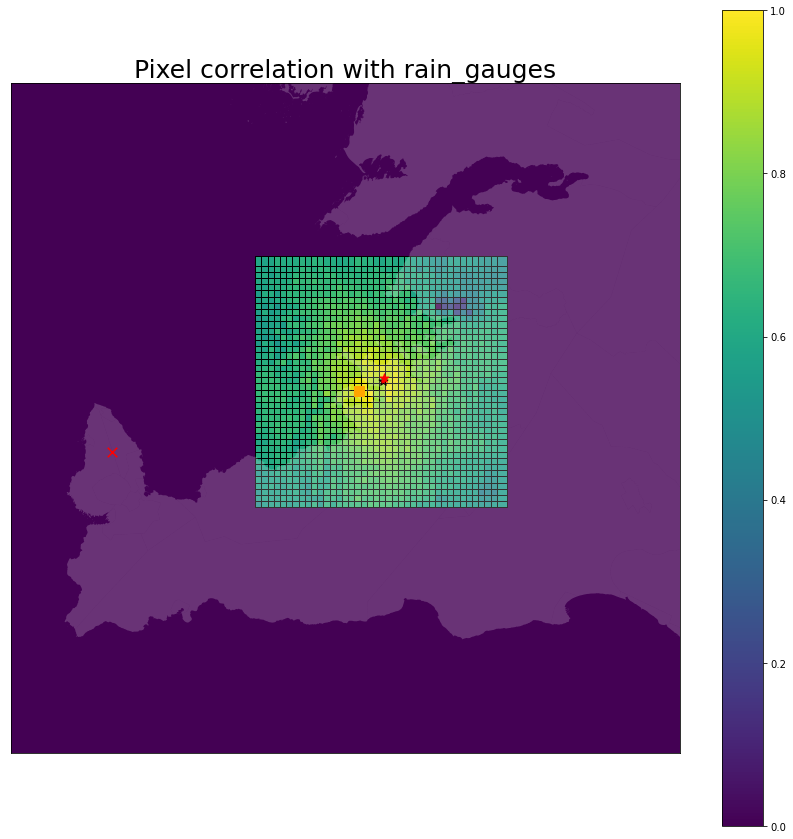

In [261]:

margin = 20

CAPPI_indexes = np.arange(602**2).reshape(602,602)
cappi_idx = CAPPI_indexes[gauge_idx-margin:gauge_idx+margin,gauge_idy-margin:gauge_idy+margin].ravel()

plt.figure(figsize=(15,15))
pixels_handle = plt.scatter(coords[cappi_idx,0],coords[cappi_idx,1],
                            s = 100,marker = 's',edgecolors='black',c=corrs_1475,)

postnr.geometry.plot(ax = plt.gca(),alpha = 0.2,color='white')

radar_handle = plt.scatter(radar_x,radar_y,c ='red',marker = 'x',s = 90)
gauge_handle = plt.scatter(gauge_x,gauge_y,c ='red',marker = '*',s = 90,edgecolors='black')
gauge_handle = plt.scatter(coords[cappi_idx][closest_to_gauge_idx,0],
                           coords[cappi_idx][closest_to_gauge_idx,1],c ='red',marker = '*',s = 90)

best_pixel_1475_handle = plt.scatter(coords[cappi_idx][best_pixel_1475,0],coords[cappi_idx][best_pixel_1475,1],s = 100,marker = 's',color='orange',edgecolors='orange')
plt.colorbar()
plt.ylim(gauge_y - 50_000,gauge_y + 40_000)
plt.xlim(gauge_x - 50_000,gauge_x + 40_000)
plt.xticks([],[])
plt.yticks([],[])
plt.gca().set_facecolor((0.267004, 0.004874, 0.329415, 1.0))
plt.title('Pixel correlation with rain_gauges',fontsize=25)
# plt.legend([radar_handle,gauge_handle,pixels_handle,best_pixel_1475_handle,best_pixel_1481_handle,best_pixel_1473_handle],
#         ['Radar','Primary Rain-gauge','CAPPI pixels','reykjavík','hólmsheiði','straumsvík'],loc = 'upper left',fontsize=15)
plt.show()

array([0.43385169, 0.46784221, 0.47334332, ..., 0.44342431, 0.44555443,
       0.43158687])

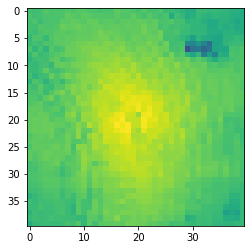

In [269]:
plt.imshow(corrs_1475.reshape(margin*2,margin*2)[::-1],vmin = 0, vmax = 0.7)
plt.show()

<AxesSubplot:>

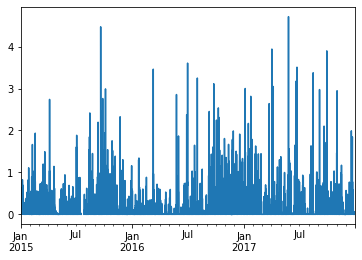

In [263]:
x_radar.resample('1h').mean().plot()
# x_gauge.resample('1h').mean().plot()

In [143]:
# for i,r in df_cappi_all.loc['2017-12-31 23:25:00':'2018-01-01 00:50:00'].iterrows():
#     plt.imshow(r.values.reshape(20,20))
#     plt.title(i)
#     plt.colorbar()
#     plt.show()

In [168]:
df_cappi_all.loc['2018-01-01 00:00:00' : '2018-01-01 00:20:00']

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399


In [170]:
# df_cappi_all.loc[df_cappi_all.index.duplicated(False)].sort_index().iloc[:2].diff().T.plot()

In [171]:
# df_cappi_all.index.unique() == df_cappi_all_merged.index.unique()

## Check that values from same month with different files have same values

## Tanslate into pandas dataframe with datetime index

# Helper functions

In [ ]:
def to_rainfall(radar_data,a = 200,b = 1.6):
    return wrl.zr.z_to_r(wrl.trafo.idecibel(offset + gain * radar_data), a=a, b=b)

# Decide subset of radar data to use

In [ ]:
# from scipy.sparse import load_npz,save_npz
# gain,offset = (0.5, -32.0)
# def to_rainfall(radar_data):
#     return wrl.zr.z_to_r(wrl.trafo.idecibel(offset + gain * radar_data), a=200, b=1.6)


# radar_csc = load_npz(DIR_data + 'radar_2020_sparse_csc_matrix.npz')


In [224]:
# get CAPPI data around pixel of interest (188168)
ix,iy = 188168//602,188168%602
x_shift = 1
y_shift = -1
print('pixel center:',ix,iy)
# x_magin = 4+5 #  pixels
# y_margin = 6+5 #  pixels
x_magin = 20 #  pixels
y_margin = 30 #  pixels
ix_start = ix + x_shift - x_magin
ix_end = ix + x_shift + x_magin
iy_start = iy + y_shift - y_margin
iy_end = iy + y_shift + y_margin


pixel center: 312 344


In [225]:
radar_patch_coords = radar_coords.reshape((602,602,-1))[ix_start:ix_end,iy_start:iy_end,:2].reshape(-1,2)
radar_patch_coords_gps = [transformer_isl_gps.transform(a,b) for a,b in radar_patch_coords]

NameError: name 'radar_coords' is not defined

In [ ]:
import folium
import shapely
from shapely import geometry, ops
def get_frame(centre = [64.1285031, -21.9524],scale=1):
    x,y = centre
    dx = 0.004*scale
    dy = 0.01*scale

    outline = shapely.geometry.box(x-dx,y-dy,x+dx,y+dy).boundary
    return x,y,outline

center = [64.1274, -21.9024]
m = folium.Map(
    location=center,
    zoom_start=12,
    tiles='openstreetmap'
)

x,y,outline = get_frame(center,  20)

# for tmp_coords in coordinates:
#     tmp_x_y_gps = tmp_coords.reshape(-1,3)[:,:-1]

for coords in radar_patch_coords_gps:
    shapely_point = shapely.geometry.Point(coords)
    # if outline.convex_hull.contains(shapely_point):
    folium.Marker([coords[0],coords[1]]).add_to(m)


m.save(f'{x_magin*2}times{y_margin*2}_CAPPI_raw.html')

NameError: name 'radar_patch_coords_gps' is not defined

In [ ]:
radar_patches = []
raw_radar_patches = []
for i in range(12):
    radar_tmp = np.load(DIR_data + f'CAPPI_{i}.npy')
    radar_tmp = radar_tmp.reshape(-1,602,602)
    tmp_patches = radar_tmp[:,ix_start:ix_end,iy_start:iy_end]
    raw_radar_patches.append(np.copy(tmp_patches))
    tmp_rainfall_patch = to_rainfall(tmp_patches)
    radar_patches.append(tmp_rainfall_patch)
    
radar_patches = np.concatenate(radar_patches,axis = 0)
average_precipitation = np.mean(radar_patches,axis = (1,2))

raw_radar_patches = np.concatenate(raw_radar_patches,axis = 0)

In [ ]:
# radar_patches.shape

In [ ]:
pd.DataFrame(radar_patches.reshape(-1,(x_magin*2)*(y_margin*2)),dates).to_pickle(f'{x_magin*2}times{y_margin*2}_CAPPI_raw')
pd.DataFrame(raw_radar_patches.reshape(-1,(x_magin*2)*(y_margin*2)),dates).to_pickle(f'{x_magin*2}times{y_margin*2}_CAPPI_raw_echo')


In [ ]:
np.max(raw_radar_patches)

127

In [ ]:
df.index[df.index <= gauges.index.max()]
gauges.resample('1h').sum().loc[df.index[df.index <= gauges.index.max()],'1473'].values

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
precipitation_series = pd.Series(average_precipitation,index = pd.DatetimeIndex(dates))
precipitation_series_1h = precipitation_series.resample('1h').sum()
gauges_hourly = gauges.resample('1h').sum()

<AxesSubplot:>

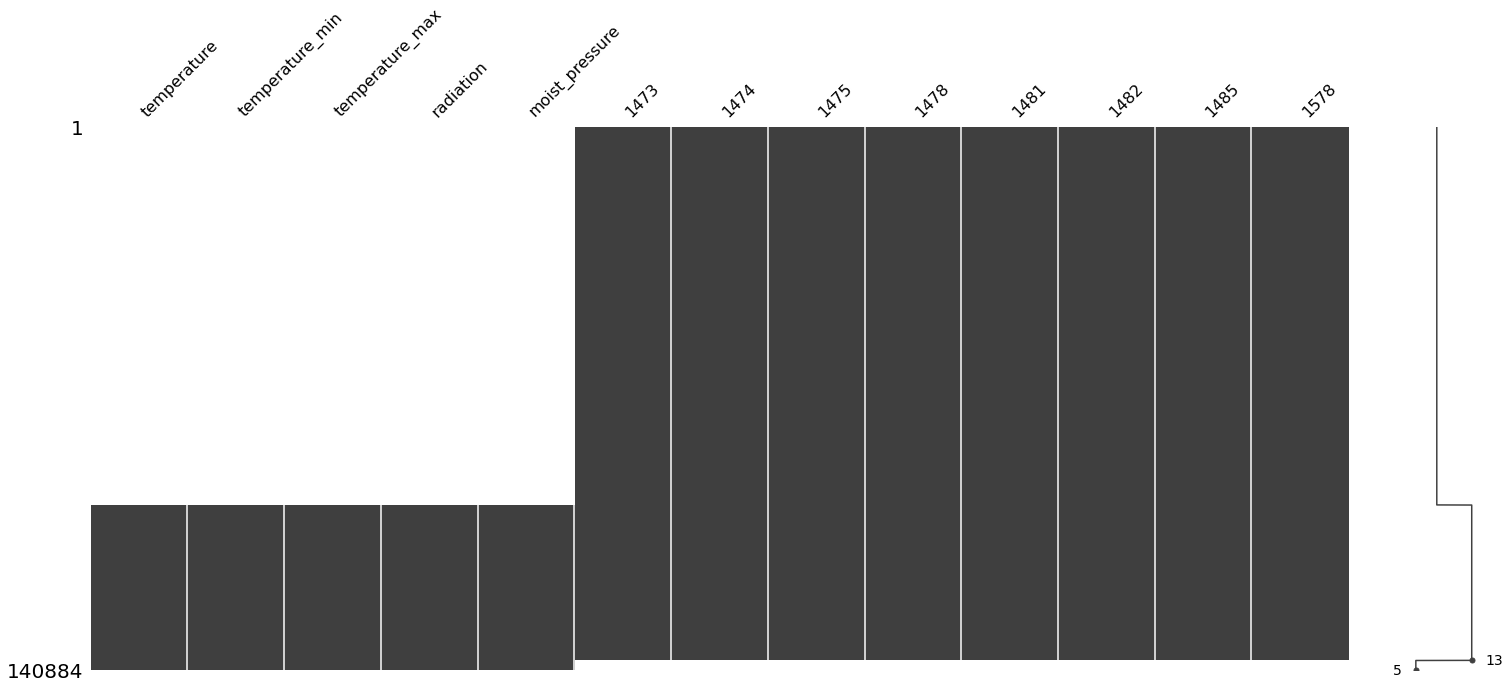

In [ ]:

df = pd.concat([df_weather,gauges_hourly],axis=1)
df.to_pickle('input_data')

In [ ]:
areas = radar_patches[:,:3,:5,np.newaxis],radar_patches[:,3:,:5,np.newaxis],radar_patches[:,:3,5:,np.newaxis],radar_patches[:,3:,5:,np.newaxis],
four_area_average_patches = np.concatenate(areas,axis=3).mean(axis=(1,2))

precipitation_series_areas = pd.DataFrame(four_area_average_patches,index = pd.DatetimeIndex(dates))
precipitation_series_1h_areas = precipitation_series_areas.resample('1h').sum()

df = df_weather.copy()
df.loc[:,'gauge'] = gauges.loc[df.index,'1473'].values
df.loc[precipitation_series_1h_areas.index,['1','2','3','4']] = precipitation_series_1h_areas.values

df.to_pickle('2020_input_data_four_areas')

In [ ]:
radar_patches.shape

In [ ]:
# pd.DataFrame(radar_patches.reshape(-1,8*12),dates).to_pickle('8times12_CAPPI_raw')

In [ ]:
radar_patches.shape

In [ ]:
# from missingno import matrix
# matrix(gauges.loc[datetime.datetime(2020,1,1,0,0,0):datetime.datetime(2021,1,1,0,0,0)])